## Task 3.1 Convergence and attractors

In [1]:
import numpy as np

#### Initialize some data from lab instructions

In [2]:
x1=np.array([-1, -1, 1, -1, 1, -1, -1, 1])
x2=np.array([-1, -1, -1, -1, -1, 1, -1, -1])
x3=np.array([-1, 1, 1, -1, -1, 1, -1, 1])

x1d=np.array([ 1, -1, 1, -1, 1, -1, -1, 1])
x2d=np.array([ 1, 1, -1, -1, -1, 1, -1, -1])
x3d=np.array([ 1, 1, 1, -1, 1, 1, -1, 1,])

#### Synchronous Hopfield - note, all data is in row format

In [3]:
class Hopfield_net():
    def __init__(self, data, scale=False):
        self.data = data
        self.W = np.zeros((data.shape[1], data.shape[1]))
        self.scale = scale
        self.hebian_learn()

    def hebian_learn(self):
        for i in range(self.data.shape[0]):
            self.W += np.outer(self.data[i], self.data[i])
        if self.scale:
            self.W /= self.data.shape[0]

    # Numpy sign sets sign of 0 to 0 - change it to 1
    def hop_sign(self, dp):
        temp = np.sign(dp)
        return np.where(temp == 0, 1, temp)
    
    def recall_sync(self, dp):
        recall_prev = np.copy(dp)
        recall = self.hop_sign(np.matmul(np.copy(dp), self.W))
        while not np.array_equal(recall, recall_prev):
            recall_prev = np.copy(recall)
            recall = self.hop_sign(np.matmul(recall, self.W))
        return recall.astype(int)

    def recall_seq(self, dp, random=False):
        order = np.arange(dp.shape[0])
        if random:
            np.random.shuffle(order)
        recall_prev = np.copy(dp)
        recall = self.seq_update(dp, order)
        while not np.array_equal(recall, recall_prev):
            if random:
                np.random.shuffle(order)
            recall_prev = np.copy(recall)
            recall = self.seq_update(recall, order)
        return recall.astype(int)

    # Helper func to sequential update - makes one pass of sequential updates for all points
    def seq_update(self, recall, order):
        ret = np.copy(recall)
        for i in range(order.shape[0]):
            ret[order[i]] = self.hop_sign(np.matmul(self.W[order[i]], ret.transpose()))
        return ret

#### Some test funcs to see if recall recalls properly

In [4]:
def test_recall_sync(data, data_dist, test_net=None, printout=True):
    if test_net is None:
        test_net = Hopfield_net(data)
    for i in range(data.shape[0]):
        recalled = test_net.recall_sync(data_dist[i])
        did_recall = np.array_equal(data[i], recalled)
        print("x{} recalled properly: {}".format(i + 1, did_recall))
        if not did_recall and printout:
            print("\torig: {}".format(np.array2string(data[i])))
            print("\tdist: {}".format(np.array2string(data_dist[i])))
            print("\trecl: {}".format(np.array2string(recalled)))

def test_recall_seq(data, data_dist, test_net=None, printout=True):
    if test_net is None:
        test_net = Hopfield_net(data)
    for i in range(data.shape[0]):
        recalled = test_net.recall_seq(data_dist[i])
        did_recall = np.array_equal(data[i], recalled)
        print("x{} recalled properly: {}".format(i + 1, did_recall))
        if not did_recall and printout:
            print("\torig: {}".format(np.array2string(data[i])))
            print("\tdist: {}".format(np.array2string(data_dist[i])))
            print("\trecl: {}".format(np.array2string(recalled))) 

##### Some sanity checks

In [5]:
data = np.vstack((x1, x2, x3))
test_recall_sync(data, data)
test_recall_seq(data, data)

x1 recalled properly: True
x2 recalled properly: True
x3 recalled properly: True
x1 recalled properly: True
x2 recalled properly: True
x3 recalled properly: True


###  Actual 3.1

#### Check convergence of distorted data points

In [6]:
data = np.vstack((x1, x2, x3))
data_dist = np.vstack((x1d, x2d, x3d))
test_recall_sync(data, data_dist)
test_recall_seq(data, data_dist)

x1 recalled properly: True
x2 recalled properly: False
	orig: [-1 -1 -1 -1 -1  1 -1 -1]
	dist: [ 1  1 -1 -1 -1  1 -1 -1]
	recl: [-1  1 -1 -1 -1  1 -1 -1]
x3 recalled properly: True
x1 recalled properly: True
x2 recalled properly: False
	orig: [-1 -1 -1 -1 -1  1 -1 -1]
	dist: [ 1  1 -1 -1 -1  1 -1 -1]
	recl: [-1  1 -1 -1 -1  1 -1 -1]
x3 recalled properly: True


#### Check for all attractors

In [7]:
# Please change this if you get a better idea than to brute force it with all possible input vectors
def dp_builder(dim):
    vec = np.zeros(dim)
    return dp_builder_h(dim, vec, 0)
def dp_builder_h(dim, curr_vec, curr_ind):
    # Need to copy so vec2 does not mess this up later
    vec1 = np.copy(curr_vec)
    vec1[curr_ind] = 1
    # Don't need to copy since no one else will use curr_vec
    vec2 = curr_vec
    vec2[curr_ind] = -1
    # Base case, reached last index of vector
    if dim == curr_ind + 1:
        return np.vstack((vec1, vec2))
    else:
        return np.vstack((
            dp_builder_h(dim, vec1, curr_ind + 1),
            dp_builder_h(dim, vec2, curr_ind + 1)
        ))        

In [8]:
data = np.vstack((x1, x2, x3))
test_net = Hopfield_net(data)
all_dp = dp_builder(x1.shape[0])
attractors = np.zeros(all_dp.shape)

# Brute force it - recall for every possible input vector
for i in range(all_dp.shape[0]):
    attractors[i] = test_net.recall_sync(all_dp[i])

# Remove duplicates
attractors = np.unique(attractors, axis=0)
print(attractors)
print("In total {} attractors".format(attractors.shape[0]))
    

[[-1. -1. -1. -1. -1.  1. -1. -1.]
 [-1. -1. -1. -1.  1. -1. -1. -1.]
 [-1. -1.  1. -1. -1.  1. -1.  1.]
 [-1. -1.  1. -1.  1. -1. -1.  1.]
 [-1. -1.  1. -1.  1.  1. -1.  1.]
 [-1.  1. -1. -1. -1.  1. -1. -1.]
 [-1.  1.  1. -1. -1.  1. -1.  1.]
 [-1.  1.  1. -1.  1. -1. -1.  1.]
 [ 1. -1. -1.  1.  1. -1.  1. -1.]
 [ 1.  1. -1.  1. -1.  1.  1. -1.]
 [ 1.  1. -1.  1.  1. -1.  1. -1.]
 [ 1.  1. -1.  1.  1.  1.  1. -1.]
 [ 1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1. -1.  1.  1.]]
In total 14 attractors


#### Testing even more distorted patterns

In [9]:
# Flip first 5 
x1_superd=np.copy(x1)
for i in range(x1.size // 2 + 1):
    x1_superd[i] = x1_superd[i] * -1

test_recall_sync(x1.reshape((1, -1)), x1_superd.reshape((1, -1)), test_net)
    

x1 recalled properly: False
	orig: [-1 -1  1 -1  1 -1 -1  1]
	dist: [ 1  1 -1  1 -1 -1 -1  1]
	recl: [ 1  1  1  1  1 -1  1  1]


## 3.2 Sequential Update

#### Load the data

In [10]:
file_path_pic_data = 'data/pict.dat'

num_pics = 11
num_attrs = 1024

# Open file and read in the array from string to int
raw_data = []
with open(file_path_pic_data, 'r') as file:
    for line in file:
        raw_data = list(map(int, line.split(',')))
        # It should only be a single line but just in case
        break
pic_data = np.array(raw_data).reshape(num_pics, num_attrs)

# Sanity check that we did the reshaping right
for i in range(num_pics):
    for j in range(num_attrs):
        if raw_data[num_attrs*i + j] != pic_data[i, j]:
            print("Error, reshape incorrect!")

pic_data_dist = pic_data[9:]
pic_data = pic_data[:9]

#### Define function for drawing the pictures

In [11]:
import matplotlib.pyplot as plt

def show_image_from_vec(dp, title=None):
    im_data = dp.reshape(32, 32)
    plt.imshow(im_data)
    if title is not None:
        plt.title(title)
    plt.show()

#### Train with 3 pictures

In [12]:
pic_data_3 = pic_data[:3]
test_recall_seq(pic_data_3, pic_data_3)

x1 recalled properly: True
x2 recalled properly: True
x3 recalled properly: True


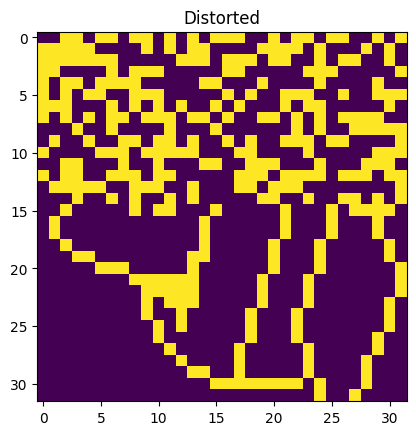

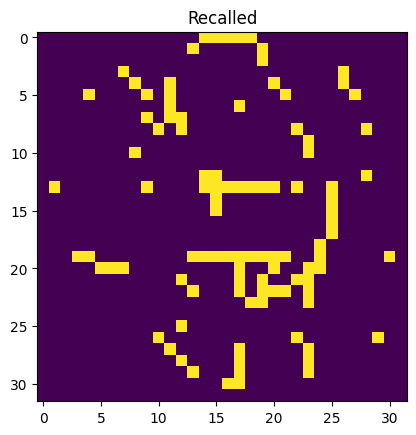

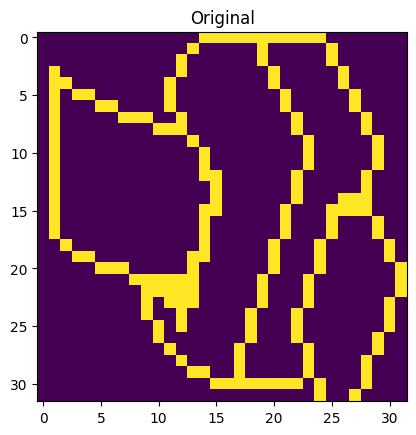

Recalled x1: False


In [13]:
pic_net = Hopfield_net(pic_data_3)
#test_recall_seq(pic_data_3[0].reshape((1, -1)), pic_data_dist[0].reshape((1, -1)), printout=False, test_net=pic_net)
did_recall_x1 = np.array_equal(pic_data_3[0], pic_net.recall_seq(pic_data_dist[0]))
show_image_from_vec(pic_data_dist[0], title="Distorted")
show_image_from_vec(pic_net.recall_seq(pic_data_dist[0]), title="Recalled")
show_image_from_vec(pic_data_3[0], title="Original")
print("Recalled x1: {}".format(did_recall_x1))

### Check the other distorted pic

Recalled x2: True
Recalled x3: False


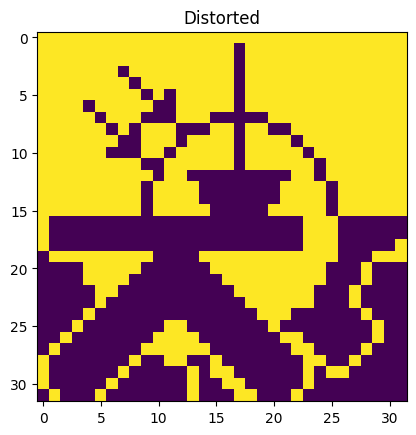

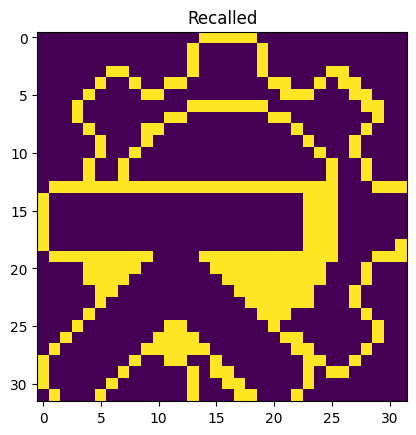

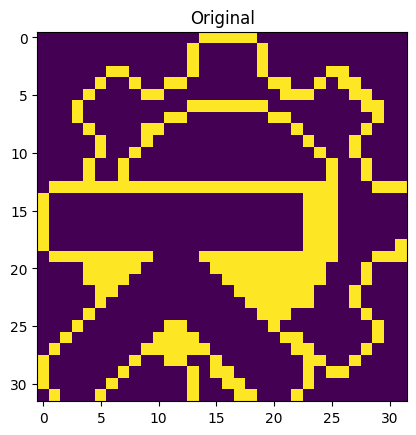

In [17]:
#pic_dist = np.vstack((pic_data_dist[1], pic_data_dist[1])).reshape((2, -1))
#test_recall_seq(pic_data_3[1:2].reshape((2, -1)), pic_dist, printout=False, test_net=pic_net)

did_recall_x2 = np.array_equal(pic_data_3[1], pic_net.recall_seq(pic_data_dist[1]))
did_recall_x3 = np.array_equal(pic_data_3[2], pic_net.recall_seq(pic_data_dist[1]))
print("Recalled x2: {}".format(did_recall_x2))
print("Recalled x3: {}".format(did_recall_x3))
show_image_from_vec(pic_data_dist[1], title="Distorted")
show_image_from_vec(pic_net.recall_seq(pic_data_dist[1]), title="Recalled")
show_image_from_vec(pic_data_3[1], title="Original")

### Make a new Hopfield net since they want us to print during recall - less messy (but still messy)

In [15]:
class Hopfield_net_pics(Hopfield_net):
    def __init__(self, data, scale=False):
        super().__init__(data, scale=scale)
        self.it = 0

    # Overwrite to print pictures
    def seq_update(self, recall, order):
        for i in range(order.shape[0]):
            ret = np.copy(recall)
            if self.it % 100 == 0:
                show_image_from_vec(ret, title="Recall after {} iterations".format(self.it))
            ret[order[i]] = self.hop_sign(np.matmul(self.W[order[i]], ret.transpose()))
            self.it += 1
        return ret

In [ ]:
### This part is a bit buggy - recall worked fine in cell above but now printing pics suddenly does not, probably some variable 

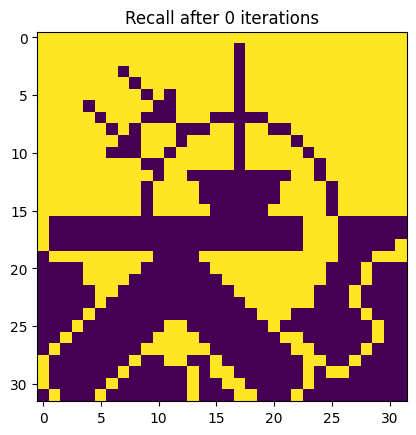

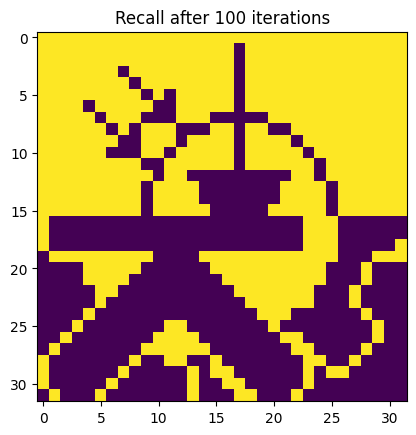

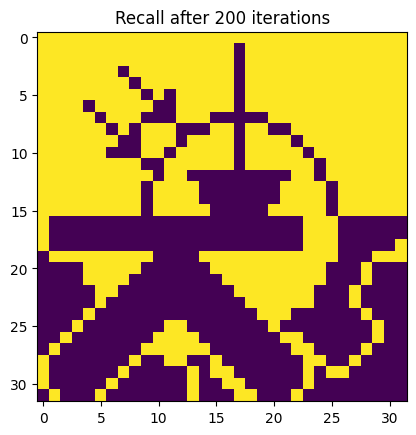

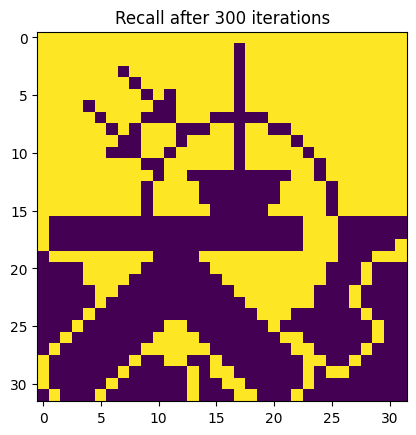

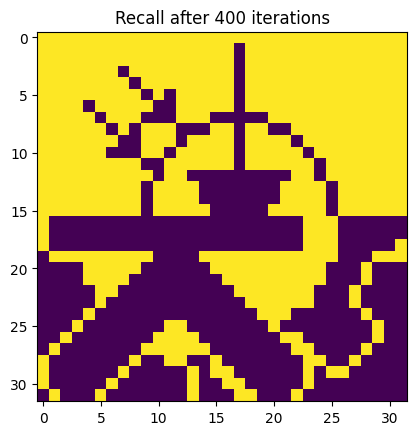

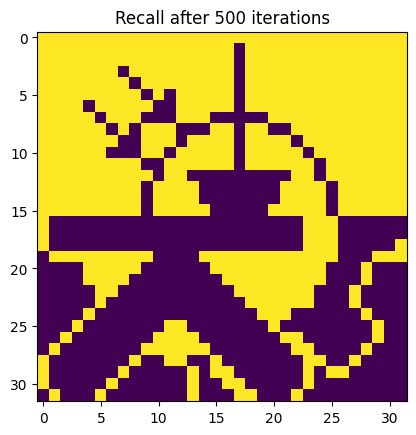

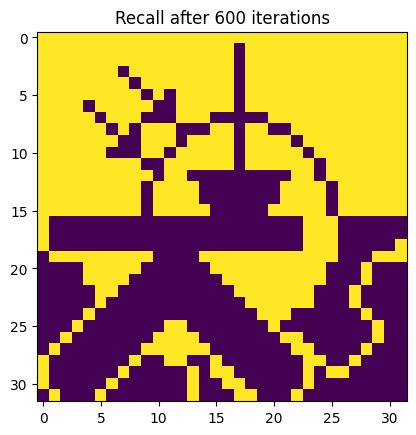

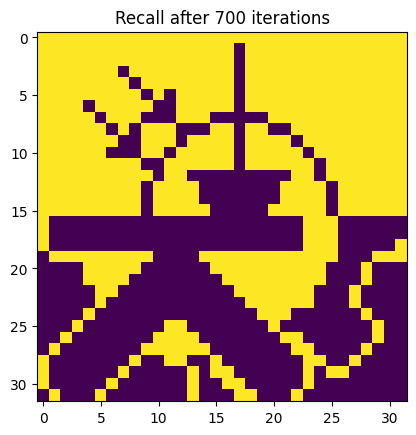

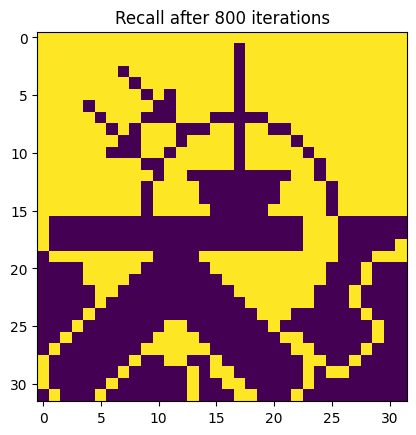

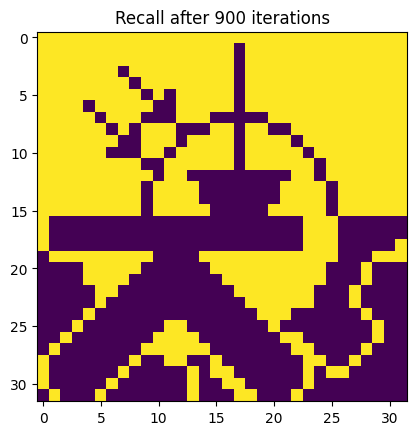

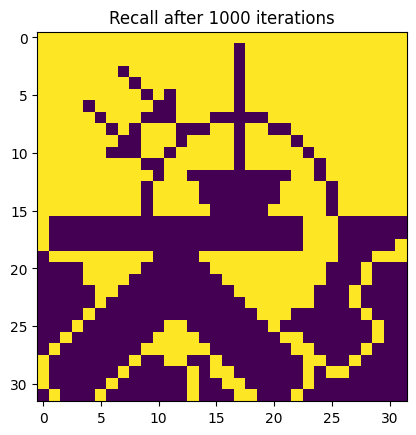

array([ 1,  1,  1, ..., -1, -1, -1])

In [19]:
pic_net_printing = Hopfield_net_pics(pic_data_3)
pic_net_printing.recall_seq(pic_data_dist[1], random=True)
#show_image_from_vec(pic_dist[0])

## 3.3 Energy